In [1]:
import pandas as pd
import random
import csv

import numpy as np

import matplotlib.pyplot as plt
from pylab import rcParams

import networkx as nx
from scipy import stats

import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

from shapely.geometry import LineString
import mapclassify as mc

In [2]:
AIRPORT_ORIGIN = 27
TIME_ORIGIN = 1229231100

# Part 1: Infection spread simulation

In [3]:
def get_infected_airports(df, p=1.e-6):
    times = []
    #the assumption is that the infection starts
    #in the airport with id 27, with the first flight already infected
    infected_airports = {AIRPORT_ORIGIN: TIME_ORIGIN - TIME_ORIGIN}
    for row in df.itertuples():
        _, id1, id2, time_start, time_stop, duration = row
        id1, id2 = int(id1), int(id2)
        times.append(int(time_start))
        time_start = int(time_start) - TIME_ORIGIN
        time_stop = int(time_stop) - TIME_ORIGIN

        if id1 in infected_airports and not id2 in infected_airports:
            if random.random() < p:
                infected_airports[id2] = time_stop
    #print(np.min(times))
    return infected_airports

In [4]:
flights_df = pd.read_csv('graph_disease/events_US_air_traffic_GMT-1801-929483.txt', sep=' ')
flights_df.sort_values(by = 'StartTime', inplace=True)
#SORT ALL THE FLIGHTS BY THEIR TIME
#ASSUME THE INFECTION STARTS AT THE AIRPORT WITH ID 27 (Salt Lake City),
#THE ONE WITH THE EARLIERST FLIGHT
#ALL INFECTION TIMES ARE MEASURED WITH RESPECT TO THE TIME OF THE FIRST FLIGHT

In [5]:
airport_data_df = pd.read_csv('./graph_disease/US_airport_id_info-1801-1566ad.csv')

In [6]:
airport_data_df.query('id == 27')

,id,symbol,airport name,city,latitude,longitude,xcoordviz,ycoordviz
27,27,SLC,Salt Lake City Intl,Salt Lake City,40.788389,-111.977772,-1.121073e+06,188655.57638


In [7]:
TOTAL_AIRPORTS = len(airport_data_df.id.unique())

In [8]:
p_s = [0.01, 0.05, 0.1, 0.5, 1]
NTRIALS = 10

simulation = {}
for p in p_s:
    simulation[p] = []
    for i in range(NTRIALS):
        simulation[p].append(get_infected_airports(flights_df, p))

In [9]:
num_infected = {}
for p in p_s:
    num_infected[p] = np.zeros(10)
    for trial in simulation[p]:
        for v in trial.values():
            for idx in range(len(num_infected[p])):
                if v < 12*(idx)*60*60:
                    num_infected[p][idx] += 1.0/NTRIALS/TOTAL_AIRPORTS
                    #overall scaling, this should be correct?

# Part 2: Infection spread vs p

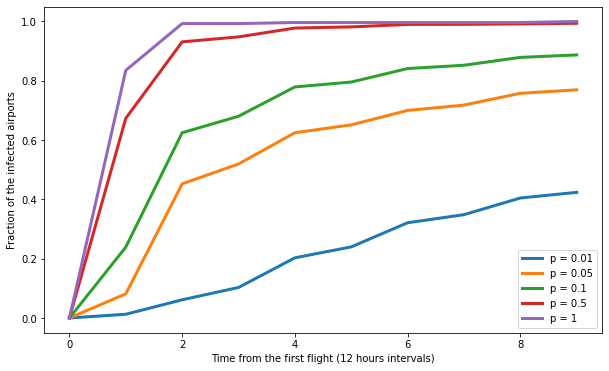

In [13]:
rcParams['figure.figsize'] = 10, 6
for p in p_s:
    plt.plot(num_infected[p], label=f'p = {p}', linewidth=3)
plt.xlabel('Time from the first flight (12 hours intervals)')
plt.ylabel('Fraction of the infected airports')
plt.legend()

The interpretation of the plot is straightforward. 
Remarkable, however, is the step in the infection rates between p = 0.01 and p = 0.05.

# Part 3: graph properties and median infection times

In [37]:
NTRIALS_2 = 100
simulation_2 = []
p_2 = 0.5
for i in range(NTRIALS_2):
    simulation_2.append(get_infected_airports(flights_df, p_2))

In [38]:
infection_times = {} #id, time
for trial in simulation_2:
    for k, v in trial.items():
        if k in infection_times:
            infection_times[k].append(v)
        else:
            infection_times[k] = [v]

In [39]:
median_times = {k: np.median(v)/60/60 for k, v in infection_times.items()}

In [19]:
connections = {}
connections_total = 0
for row in flights_df.itertuples():
    connections_total+=1
    _, id1, id2, time_start, time_stop, duration = row
    id1, id2 = int(id1), int(id2)
    if id1 < id2:
        key = (id1, id2)
    else:
        key = (id2, id1)
    connections[key] = connections.get(key, 0) + 1

In [20]:
G = nx.Graph()
for k in connections:
    G.add_edge(*k, weight=connections[k])

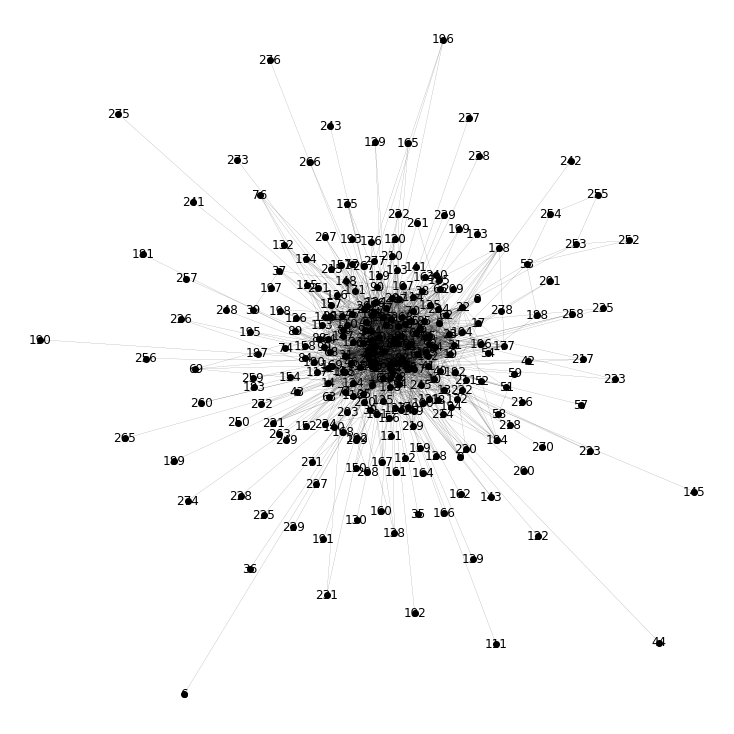

In [21]:
rcParams['figure.figsize'] = 10, 10
options = {
    "node_color": "black",
    "node_size": 50,
    "linewidths": 0,
    "width": 0.1,
    'with_labels': True,
}
nx.draw_kamada_kawai(G, **options)
plt.show()

# Flight network geo visuals

In [40]:
airport_data_geo_df = gpd.GeoDataFrame(
        airport_data_df, 
        geometry=gpd.points_from_xy(airport_data_df.longitude, airport_data_df.latitude))

In [41]:
#really nice functionality:
#airport_data_geo_df['degree'] = airport_data_geo_df['id'].map(degree)
airport_data_geo_df['degree'] = airport_data_geo_df['id'].map(lambda id: G.degree(id))
airport_data_geo_df['clustering'] = airport_data_geo_df['id'].map(nx.clustering(G))
airport_data_geo_df['btw_centrality'] = airport_data_geo_df['id'].map(nx.betweenness_centrality(G))

In [42]:
def inverse_(x):
    if x > 1.e-6:
        return 1./x
    else:
        return 0.

In [43]:
airport_data_geo_df['median_infection_time'] = airport_data_geo_df['id'].map(median_times)
airport_data_geo_df['median_infection_time_inverse'] = airport_data_geo_df['median_infection_time'].apply(inverse_)

In [44]:
#cutoff mainland US
connections_geo = []
weights_geo = []
for k,v in connections.items():
    id1, id2 = k[0], k[1]
    lon1 = airport_data_df[airport_data_df.id == id1].longitude
    lat1 = airport_data_df[airport_data_df.id == id1].latitude
    lon2 = airport_data_df[airport_data_df.id == id2].longitude
    lat2 = airport_data_df[airport_data_df.id == id2].latitude
    
    line = LineString([(lon1, lat1), (lon2, lat2)])
    weight = v
    connections_geo.append(line)
    weights_geo.append(weight)

In [45]:
connections_df = pd.DataFrame({'geometry': connections_geo,
                                   'Weight': weights_geo})
connections_geo_df = gpd.GeoDataFrame(connections_df)

In [46]:
scheme_connection_weights = mc.Quantiles(connections_geo_df['Weight'], k=8)
scheme_airport_degree =  mc.Quantiles(airport_data_geo_df['degree'], k=8)
scheme_infection_time_inverse = mc.Quantiles(airport_data_geo_df['median_infection_time_inverse'], k=8)

In [29]:
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or Linear

IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or Linear

<GeoAxesSubplot:title={'center':'US airports by the inverse of the median infection time'}>

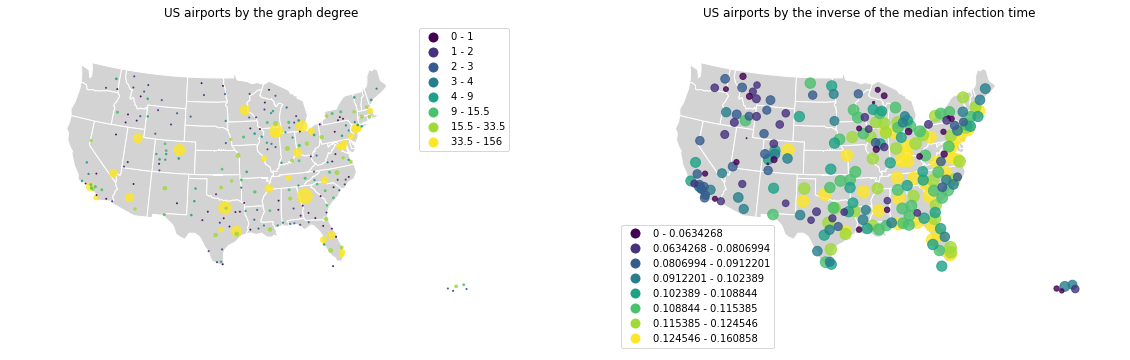

In [47]:
proj = gcrs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5)
fig = plt.figure(figsize=(20,14))
ax1 = plt.subplot(121, projection=proj)
ax2 = plt.subplot(122, projection=proj)


ax1.set(title='US airports by the graph degree')
ax2.set(title='US airports by the inverse of the median infection time')

gplt.polyplot(
    contiguous_usa, projection=proj,
    edgecolor='white', facecolor='lightgray',
    ax=ax1
)

#gplt.sankey(
#    connections_geo_df,
#    ax = ax,
#    scale='Weight', hue='Weight', scheme=scheme_connection_weights, 
#    cmap='Greens', legend=True,
#)

#only mainland USA
gplt.pointplot(
    airport_data_geo_df[airport_data_geo_df.longitude > -120],
    hue=airport_data_geo_df['degree'],
    scale=airport_data_geo_df['degree'],
    limits=(1, 15),
    ax = ax1,
    alpha=0.8,
    scheme=scheme_airport_degree,
    legend=True,
)


###
gplt.polyplot(
    contiguous_usa, projection=proj,
    edgecolor='white', facecolor='lightgray',
    ax=ax2
)

#only mainland USA
gplt.pointplot(
    airport_data_geo_df[airport_data_geo_df.longitude > -120],
    hue=airport_data_geo_df['median_infection_time_inverse'],
    scale=airport_data_geo_df['median_infection_time_inverse'],
    limits=(1, 15),
    ax = ax2,
    alpha=0.8,
    scheme=scheme_infection_time_inverse,
    legend=True,
)

The plot is noisy, but it is possible to recognize a correlation: the airports having a high degree have a large inverse of the infection time, i.e. are infected first.

# Correlation plots: vertex properties vs infection time

### Inversed median infection time versus vertex (airport) DEGREE

Text(0, 0.5, 'Inverse of the median infection time (1/hour)')

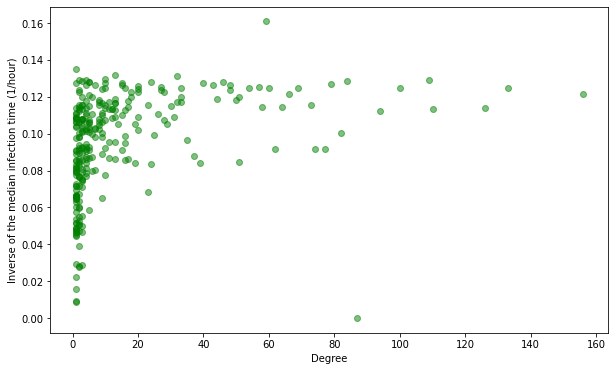

In [49]:
rcParams['figure.figsize'] = 10, 6
plt.scatter(airport_data_geo_df['degree'], 
            airport_data_geo_df['median_infection_time_inverse'], 
            alpha=0.5, c='green')
plt.xlabel('Degree')
plt.ylabel('Inverse of the median infection time (1/hour)')

### Inversed median infection time versus vertex (airport) CLUSTERING

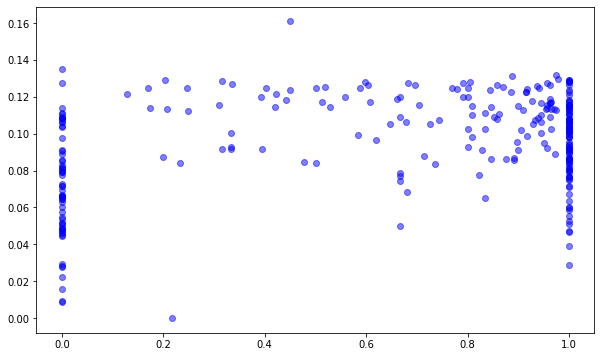

In [50]:
rcParams['figure.figsize'] = 10, 6
plt.scatter(airport_data_geo_df['clustering'], 
            airport_data_geo_df['median_infection_time_inverse'],
            alpha=0.5, c='blue')

### Inversed median infection time versus vertex (airport) BETWENNESS CENTRALITY

Text(0, 0.5, 'Inverse of the median infection time (1/hour)')

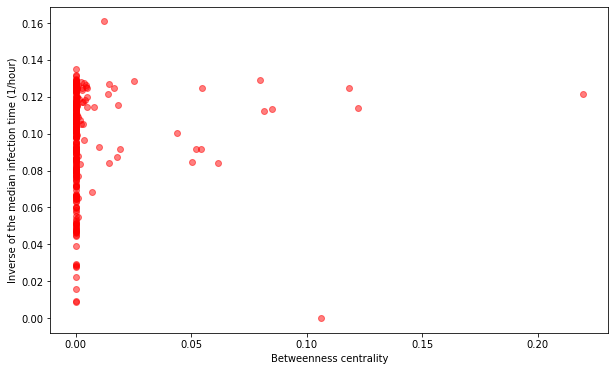

In [51]:
rcParams['figure.figsize'] = 10, 6
plt.scatter(airport_data_geo_df['btw_centrality'],
            airport_data_geo_df['median_infection_time_inverse'],
            alpha=0.5, c='red')
plt.xlabel('Betweenness centrality')
plt.ylabel('Inverse of the median infection time (1/hour)')

# Spearman's correlation coefficients

In [52]:
stats.spearmanr(airport_data_geo_df['degree'], airport_data_geo_df['median_infection_time'])[0]

-0.5895728927653177

In [53]:
stats.spearmanr(airport_data_geo_df['btw_centrality'], airport_data_geo_df['median_infection_time'])[0]

-0.4140176025767731

In [54]:
stats.spearmanr(airport_data_geo_df['clustering'], airport_data_geo_df['median_infection_time'])[0]

-0.15661248106558023

Conclusion:
The strongest negative correlation is observed for the median infection time and the degree of a vertex (i.e. an airport). The airports with a high degree (a large number of incoming and outgoing flights) are most susceptible to the infection, resuling in small values of the median infection time. The correlation is weaker for the betwenness centrality and clustering properties, probably due to the simplicity of the model.